# Learning From Data Project


This project investigates whether song lyrics can be used to automatically identify the musical genre of a song. Since different genres tend to exhibit distinct linguistic patterns, vocabulary usage, and structural characteristics, lyrics provide a meaningful source of information for text-based genre classification.This project investigates whether song lyrics can be used to automatically identify the musical genre of a song. Since different genres tend to exhibit distinct linguistic patterns, vocabulary usage, and structural characteristics, lyrics provide a meaningful source of information for text-based genre classification.

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import nltk
import time
import sys

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Sklearn tools
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder


print("Status: All libraries imported successfully.")

Status: All libraries imported successfully.


Data Preprocessing and Feature Engineering
The raw lyrics dataset was initially processed by removing instrumental tracks and entries with missing text. To ensure
high-quality input, a custom cleaning function eliminated technical noise from the Genius platform, such as structural tags like
[Chorus] or [Verse] and various metadata. This normalization process included converting all text to lowercase, removing
punctuation, and normalizing whitespaces. Furthermore, WordNetLemmatizer was used to reduce words to their dictionary base forms,
effectively minimizing vocabulary sparsity.

In addition to text cleaning, we engineered domain-specific numerical features to capture stylistic differences between genres.
These features include word count to identify high-density genres like Rap, lexical richness to detect repetitive structures
through unique word ratios, and average word length to measure linguistic complexity. Finally, tracks with fewer than 20 words were
filtered out to maintain data quality, resulting in a refined dataset that provides a robust and balanced foundation for model
training.

In [2]:
# Uploading raw data
df = pd.read_csv('lyrics_dataset_raw.csv')

# Deleting the null rows (Avoiding instrumental songs)
df = df.dropna(subset=['text'])
lemmatizer = WordNetLemmatizer()
def final_cleaner(text):
    # Deleting the "Lyrics" and name of the song
    text = re.sub(r'^.*?Lyrics', '', text)

    # Deleting the "Embed" and the technical numbers
    text = re.sub(r'\d*Embed$', '', text)

    # Deleting the texts includes "[]" like [Chorus], [Verse 1]
    text = re.sub(r'\[.*?\]', ' ', text)

    # Making the new lines spaces, converting to lowercase
    text = text.replace('\n', ' ').lower()

    # Deleting the punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Deleting unnecessarily multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(w) for w in words]

    return " ".join(lemmatized_words)

print("Data is being cleaned.")
df['clean_text'] = df['text'].apply(final_cleaner)
print(df[['text', 'clean_text']].head())
# CUSTOM FEATURE ENGINEERING
# Adding numerical characteristics that differentiate the types

# Feature 1: Word Count (Rap songs are generally much longer)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Feature 2: Vocabulary Richness/Unique word count (Measures recurring refrains)
def get_lexical_richness(text):
    words = text.split()
    if len(words) == 0: return 0
    return len(set(words)) / len(words)

df['lexical_richness'] = df['clean_text'].apply(get_lexical_richness)

# Feature 3: Average Word Length (Measures the linguistic complexity of genres)
def avg_word_len(text):
    words = text.split()
    if len(words) == 0: return 0
    return sum(len(word) for word in words) / len(words)

df['avg_word_length'] = df['clean_text'].apply(avg_word_len)

# Filtering out data that is unnecessarily short (should be at least 20 words)
df = df[df['word_count'] > 20]

print(f"Completed successfully! Number of remaining songs: {len(df)}")
print(f"Class distribution:\n{df['genre'].value_counts()}")

# Save the new CSV for modelling
df.to_csv('lyrics_dataset_final.csv', index=False, encoding='utf-8-sig')

Data is being cleaned.
                                                text  \
0  Is this the real life? Is this just fantasy?\n...   
1  Tonight, I'm gonna have myself a real good tim...   
2  Mmm num ba de\nDum bum ba be\nDoo buh dum ba b...   
3  Can \nanybody find me\nSomebody to\n love?\n\n...   
4  She keeps Moët et Chandon\nIn her pretty cabin...   

                                          clean_text  
0  is this the real life is this just fantasy cau...  
1  tonight im gon na have myself a real good time...  
2  mmm num ba de dum bum ba be doo buh dum ba beh...  
3  can anybody find me somebody to love ooh each ...  
4  she keep moët et chandon in her pretty cabinet...  
Completed successfully! Number of remaining songs: 2200
Class distribution:
genre
Hip-Hop    558
Pop        550
Rock       549
Metal      543
Name: count, dtype: int64


Feature Extraction and Hybrid Representation

Hybrid Vectorization: Following the preprocessing, we created a rich feature set by combining statistical and semantic methods. We
used TF-IDF Vectorization with 8,000 features and bigrams to capture distinctive terms, while a Bag-of-Words (BoW) model was
integrated to focus on word frequencies, which is especially useful for identifying the repetitive patterns common in genres like
Rap.

Semantic Embeddings: To capture the underlying meaning of the lyrics, we implemented Word2Vec. This model represents words in
100-dimensional space, allowing the system to understand semantic relationships even between words that do not appear together. We
then calculated the average vector for each song to create a consistent textual representation.

Feature Integration: In the final step, we merged the TF-IDF, BoW, and Word2Vec outputs with our previously engineered numerical
features (word count, lexical richness, etc.) into a single hybrid matrix. This multi-dimensional approach enables the models to
analyze both specific keywords and the overall linguistic structure of each genre simultaneously.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from scipy.sparse import hstack, csr_matrix
import numpy as np

# --- 1. TF-IDF  ---
tfidf_vectorizer = TfidfVectorizer(max_features=8000, stop_words='english', ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# --- 2. BAG-OF-WORDS (BoW) ---
bow_vectorizer = CountVectorizer(max_features=2000, stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(df['clean_text'])

# --- 3. WORD EMBEDDINGS (Word2Vec) ---
tokenized_text = [text.split() for text in df['clean_text']]
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4)

# Song-based averaging vector calculation function
def get_average_word_vector(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

# We are creating embedding attributes for all songs.
w2v_features = np.array([get_average_word_vector(tokens, w2v_model, 100) for tokens in tokenized_text])
numerical_features = df[['word_count', 'lexical_richness', 'avg_word_length']].values
# --- 4. COMBINE ALL FEATURES ---
# TF-IDF + BoW + Word2Vec + Numerical Features you created previously
X_combined_final = hstack([
    tfidf_matrix,
    bow_matrix,
    csr_matrix(w2v_features),
    csr_matrix(numerical_features) # Word count, lexical richness vb.
])

print("FEATURE ENGINEERING COMPLETE")
print(f"Total Number of Data: {X_combined_final.shape[0]}")
print(f"Total Number of Features (TF-IDF + BoW + W2V + Num): {X_combined_final.shape[1]}")

# İlk şarkı için TF-IDF skorlarını gösteren mevcut print kısmın
first_song_scores = pd.DataFrame(tfidf_matrix[0].T.todense(), 
                                 index=feature_names, 
                                 columns=["tfidf_weight"])

print("\nTop 10 words in the first song by TF-IDF weight:")
print(first_song_scores.sort_values(by="tfidf_weight", ascending=False).head(10))

FEATURE ENGINEERING COMPLETE
Total Number of Data: 2200
Total Number of Features (TF-IDF + BoW + W2V + Num): 10103

Top 10 words in the first song by TF-IDF weight:
               tfidf_weight
ooh                0.321429
let let            0.320987
really matter      0.302963
poor boy           0.259585
wind blow          0.227519
let                0.220813
poor               0.219985
mamma              0.208721
ooh ooh            0.192660
matter             0.168457


Data Scaling and Training Strategy

Following the feature extraction, the dataset was prepared for the modeling phase by converting categorical genre labels into numerical values using LabelEncoder. A critical step in this preparation was the standardization of custom numerical features—such as word count and lexical richness—using StandardScaler. This process ensured that features with different scales did not dominate the models, maintaining a balanced influence during training. These standardized features were then horizontally stacked with the TF-IDF, BoW, and Word2Vec vectors to form the final hybrid feature matrix. For the training strategy, the data was split into 75% training and 25% testing sets using a stratified sampling approach. This ensured that the original genre distribution was preserved in both sets, preventing biases and allowing for an objective performance comparison across all music genres.

In [7]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
import numpy as np


# 1. First, we define and train the encoder object.
# This step maps the texts in the 'genre' column (Rock, Pop...) to numbers such as 0, 1, 2...
genre_encoder = LabelEncoder()
df['genre_num'] = genre_encoder.fit_transform(df['genre'])
# 2. Scaling numerical attributes
# We preserve the existing attributes (word_count, lexical_richness, avg_word_length).
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[['word_count', 'lexical_richness', 'avg_word_length']])

# 3. HYBRID FEATURE COMBINATION
X_combined = hstack([
    tfidf_matrix,
    bow_matrix,
    csr_matrix(w2v_features),
    csr_matrix(scaled_numerical)
])

# NaN value check (cleans up potential gaps caused by Gensim/Word2Vec)
if np.isnan(X_combined.data).any():
    X_combined.data = np.nan_to_num(X_combined.data)

y = genre_encoder.transform(df['genre'])

# 4. Data Splitting (Train/Test Split)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Total Number of Features (TF-IDF + BoW + W2V + Numerical): {X_combined.shape[1]}")
print(f"Training Set Size (X_train): {X_train.shape[0]}")
print(f"Test Set Size (X_test): {X_test.shape[0]}")

Total Number of Features (TF-IDF + BoW + W2V + Numerical): 10103
Training Set Size (X_train): 1650
Test Set Size (X_test): 550


Model 1: Logistic Regression

Logistic Regression was selected as the baseline classification model due to its simplicity and effectiveness on high-dimensional text features. To ensure stable performance on the hybrid feature set, we applied a balanced class weight strategy to handle numerical differences between genres, giving equal importance to each class. The model was optimized with a maximum of 1,000 iterations to ensure proper convergence within the complex feature space. Following the training, the model's performance was evaluated on the test set using a comprehensive classification report, including accuracy, precision, and recall metrics to establish a reliable reference point for further comparisons.

In [8]:
# --- LOGISTIC REGRESSION TRAINING AND EVALUATION ---
lr = LogisticRegression(max_iter=1000,class_weight='balanced')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))



              precision    recall  f1-score   support

           0       0.87      0.81      0.84       139
           1       0.71      0.68      0.70       136
           2       0.66      0.64      0.65       138
           3       0.58      0.66      0.62       137

    accuracy                           0.70       550
   macro avg       0.70      0.70      0.70       550
weighted avg       0.70      0.70      0.70       550



Model 2: Support Vector Machine (SVM)

Support Vector Machine (SVM) was implemented as the second classification model, specifically utilizing the LinearSVC variant, which is highly optimized for high-dimensional feature sets. To improve generalization and prevent overfitting, we applied a regularization parameter of C=0.1, which limits the model's complexity. Additionally, a balanced class weight strategy was used to address the distribution differences between genres, ensuring that minority classes are accurately predicted. For better computational efficiency, the optimization was configured with dual=False, which is ideal when the number of features exceeds the number of samples. The final performance was analyzed through a classification report focusing on Precision, Recall, and F1-Score metrics.

In [9]:
# --- SVM TRAINING AND EVALUATION ---
# Using LinearSVC which is optimized for large text datasets
svm = LinearSVC(
    C=0.1,
    max_iter=10000,
    class_weight='balanced',
    dual=False,
    random_state=42
)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("SVM CLASSIFICATION RESULTS")
print(classification_report(y_test, y_pred_svm))

SVM CLASSIFICATION RESULTS
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       139
           1       0.70      0.69      0.70       136
           2       0.61      0.57      0.59       138
           3       0.55      0.60      0.57       137

    accuracy                           0.67       550
   macro avg       0.67      0.67      0.67       550
weighted avg       0.67      0.67      0.67       550



Model 3: Random Forest

To capture complex, non-linear relationships between features, we implemented Random Forest, an ensemble learning method that combines multiple decision trees to produce robust predictions from both textual and numerical data. To prevent overfitting and improve the model's ability to generalize to new data, we applied several constraints: max_depth=10 was set to limit how deep the trees could grow, preventing them from memorizing noise, and min_samples_leaf=5 was required to ensure each leaf focused on general patterns rather than individual outliers. Furthermore, we used a balanced class weight to address the numerical imbalances between musical genres during the training process. The model's success was ultimately evaluated through its predictions on the test set and a detailed classification report.

In [11]:
# --- RANDOM FOREST TRAINING AND EVALUATION ---
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("RANDOM FOREST RESULTS")
print(classification_report(y_test, y_pred_rf))

RANDOM FOREST RESULTS
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       139
           1       0.69      0.64      0.66       136
           2       0.64      0.74      0.69       138
           3       0.59      0.54      0.56       137

    accuracy                           0.70       550
   macro avg       0.70      0.70      0.70       550
weighted avg       0.70      0.70      0.70       550



Model 4: Multi-Layer Perceptron (MLP)

As a deep learning approach, we utilized a Multi-Layer Perceptron (MLP) to capture complex patterns within the hybrid feature space. Its fully connected layer structure allows the model to learn the non-linear relationships between textual and numerical features effectively. The architecture includes two hidden layers with 512 and 256 neurons to enable gradual information abstraction.
For the training process, we chose the ReLU activation function to model complex functions and the Adam optimizer for fast and efficient convergence. While sequential models like LSTMs are common for text, the MLP was selected for its efficiency and high performance when combined with TF-IDF and Word2Vec features on a medium-sized dataset. The training progress was monitored using the verbose=True parameter, and the final success was evaluated using standard metrics on the test set.

In [12]:
# --- MLP (NEURAL NETWORK) TRAINING AND EVALUATION ---

# hidden_layer_sizes=(512, 256): Two hidden layers (one with 512 neurons, the other with 256 neurons)
# random_state=42: To ensure the results are the same every time
mlp = MLPClassifier(hidden_layer_sizes=(512, 256), 
                    max_iter=300, 
                    activation='relu', 
                    solver='adam', 
                    random_state=42,
                    verbose=True
                )

print("Status: MLP Neural Network is training...")
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

print("\n")
print("MLP (NEURAL NETWORK) RESULTS")
print(classification_report(y_test, y_pred_mlp))

Status: MLP Neural Network is training...
Iteration 1, loss = 1.05775304
Iteration 2, loss = 0.39817832
Iteration 3, loss = 0.16719722
Iteration 4, loss = 0.05869881
Iteration 5, loss = 0.02046519
Iteration 6, loss = 0.00854379
Iteration 7, loss = 0.00452107
Iteration 8, loss = 0.00301591
Iteration 9, loss = 0.00226126
Iteration 10, loss = 0.00185148
Iteration 11, loss = 0.00156096
Iteration 12, loss = 0.00136323
Iteration 13, loss = 0.00124707
Iteration 14, loss = 0.00112449
Iteration 15, loss = 0.00103438
Iteration 16, loss = 0.00095469
Iteration 17, loss = 0.00089819
Iteration 18, loss = 0.00084466
Iteration 19, loss = 0.00079905
Iteration 20, loss = 0.00075855
Iteration 21, loss = 0.00072508
Iteration 22, loss = 0.00069259
Iteration 23, loss = 0.00066829
Iteration 24, loss = 0.00064570
Iteration 25, loss = 0.00062464
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLP (NEURAL NETWORK) RESULTS
              precision    recall  f1-score   

Overfitting Analysis

To assess overfitting, training and test accuracies were compared for all models. A large performance gap between training and test accuracy was used as an indicator of overfitting. Models with similar performance on both sets were considered to generalize well, while a significant gap suggested potential overfitting.

In [13]:
# --- OVERFITTING CHECK FOR ALL MODELS ---

models = {
    "Logistic Regression": lr,
    "SVM (LinearSVC)": svm,
    "Random Forest": rf,
    "MLP (Neural Network)": mlp
}

print(f"{'Model Name':<25} | {'Train Acc':<10} | {'Test Acc':<10} | {'Status'}")

for name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    diff = train_acc - test_acc
    if diff > 0.15:
        status = " Overfitting"
    else:
        status = " Healthy"
        
    # Correct formatting order: <10.4f
    print(f"{name:<25} | {train_acc:<10.4f} | {test_acc:<10.4f} | {status}")

Model Name                | Train Acc  | Test Acc   | Status
Logistic Regression       | 1.0000     | 0.6982     |  Overfitting
SVM (LinearSVC)           | 0.9994     | 0.6691     |  Overfitting
Random Forest             | 0.8964     | 0.7036     |  Overfitting
MLP (Neural Network)      | 1.0000     | 0.7200     |  Overfitting


Overfitting Mitigation Strategy

Initial experiments revealed that all models exhibited signs of overfitting, characterized by high training accuracy but
significantly lower test performance. To improve generalization, a comprehensive mitigation strategy was implemented.
For Logistic Regression and SVM, we applied strong L2 Regularization by significantly reducing the C parameter (to 0.001 and
0.0001). This suppressed large coefficients, forcing the models to find smoother and more general decision boundaries. In Random
Forest, we focused on Complexity Reduction by limiting the maximum tree depth to 7 and requiring at least 10 samples per leaf,
preventing the model from memorizing noise and fine-grained details.

The MLP (Neural Network) was refined using a three-fold approach:

Capacity Reduction: The number of neurons was reduced to 16 to limit the model's memorization potential.

Weight Penalty: A high Alpha (50.0) was used for L2 regularization to keep weights small.

Early Stopping: Training was automatically halted when the validation error stopped improving, ensuring the model remained in its
most stable state.

As a result of these techniques, the performance gap between training and testing was reduced below the 0.15 threshold, moving all
models into a "Healthy" status with strong generalization capabilities.

In [14]:
# Converting genre names (Rock, Pop...) into numbers (0, 1...).
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

print("Status: Labels are encoded. Ready to fix models!")

Status: Labels are encoded. Ready to fix models!


In [15]:
# By reducing the C value, we enforced model simplicity (Technique: L2 Regularization).
lr_fixed = LogisticRegression(C=0.001, max_iter=1000, class_weight='balanced')
# 1. SVM: We push the C value to an extreme level (0.0001)
# This allows the model to draw a very wide and general boundary instead of strict rules that allow almost no errors
svm_fixed = LinearSVC(
    C=0.0001,
    max_iter=20000,
    class_weight='balanced',
    dual=False,
    random_state=42
)

lr_fixed.fit(X_train, y_train_num)
svm_fixed.fit(X_train, y_train_num)
print("Status: LR and SVM are now strongly regularized.")


Status: LR and SVM are now strongly regularized.


In [16]:
# By limiting the maximum tree depth, we prevented the model from memorizing fine-grained details (Technique: Complexity Reduction).
rf_fixed = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)
rf_fixed.fit(X_train, y_train_num)
print("Status: Random Forest is now pruned more strictly.")

Status: Random Forest is now pruned more strictly.


In [17]:
# By increasing the alpha value (alpha = 5.0), we strengthened the regularization penalty to prevent the model from becoming overly complex.
# By reducing the number of neurons (hidden_layer_sizes = (128, 64)), we limited the model’s capacity to prevent memorization.

mlp_fixed = MLPClassifier(
    hidden_layer_sizes=(16,),
    alpha=50.0,              # Technique 1: Strengthened L2 Regularization
    early_stopping=True,      # Technique 2: Early Stopping
    validation_fraction=0.1,
    n_iter_no_change=15,      # The early stopping patience was reduced to 15 epochs to stop training sooner.
    random_state=42
)
mlp_fixed.fit(X_train, y_train_num)

print("Status: Training the Stronger Regularized MLP...")


Status: Training the Stronger Regularized MLP...


In [25]:
# --- FINAL OVERFITTING CHECK ---
fixed_models = {
    "Logistic Regression": lr_fixed,
    "Linear SVM ": svm_fixed,
    "Random Forest (Fixed)": rf_fixed,
    "MLP ": mlp_fixed
}

print(f"{'Model Name':<30} | {'Train Acc':<10} | {'Test Acc':<10} | {'Status'}")
print("-" * 75)

for name, model in fixed_models.items():
    tr_acc = model.score(X_train, y_train_num)
    te_acc = model.score(X_test, y_test_num)
    
    diff = tr_acc - te_acc
    # Models with a performance gap smaller than 0.15 were considered to exhibit healthy generalization.
    status = " Healthy" if diff <= 0.15 else " Overfitting"
    
    print(f"{name:<30} | {tr_acc:<10.4f} | {te_acc:<10.4f} | {status}")

Model Name                     | Train Acc  | Test Acc   | Status
---------------------------------------------------------------------------
Logistic Regression            | 0.8297     | 0.7164     |  Healthy
Linear SVM                     | 0.8182     | 0.7164     |  Healthy
Random Forest                  | 0.8145     | 0.7073     |  Healthy
MLP                            | 0.8424     | 0.7073     |  Healthy


Confusion Matrix Analysis

To evaluate model performance beyond simple accuracy, we utilized the Confusion Matrix to conduct a class-based error analysis.
This visualization reveals which music genres the models successfully distinguish and where they experience characteristic
confusion, such as the overlap between Rock and Metal.

The analysis focused on several key outcomes: The density along the diagonal line (from top-left to bottom-right) indicates how
accurately the model predicts each specific genre. Cells outside this diagonal represent systematic errors, showing where genres
with similar lyrical or instrumental backgrounds are misclassified. Furthermore, the matrix allows for a genre-based sensitivity
analysis, identifying whether certain genres like Rap—with its distinct linguistic structure—are more easily recognized than others.
The final 2×2 grid layout compares the error distributions of all four models (LR, SVM, RF, and MLP) on the same test data. This
visualization is essential for identifying the most reliable model by highlighting which architecture best handles the nuances
between specific genres.

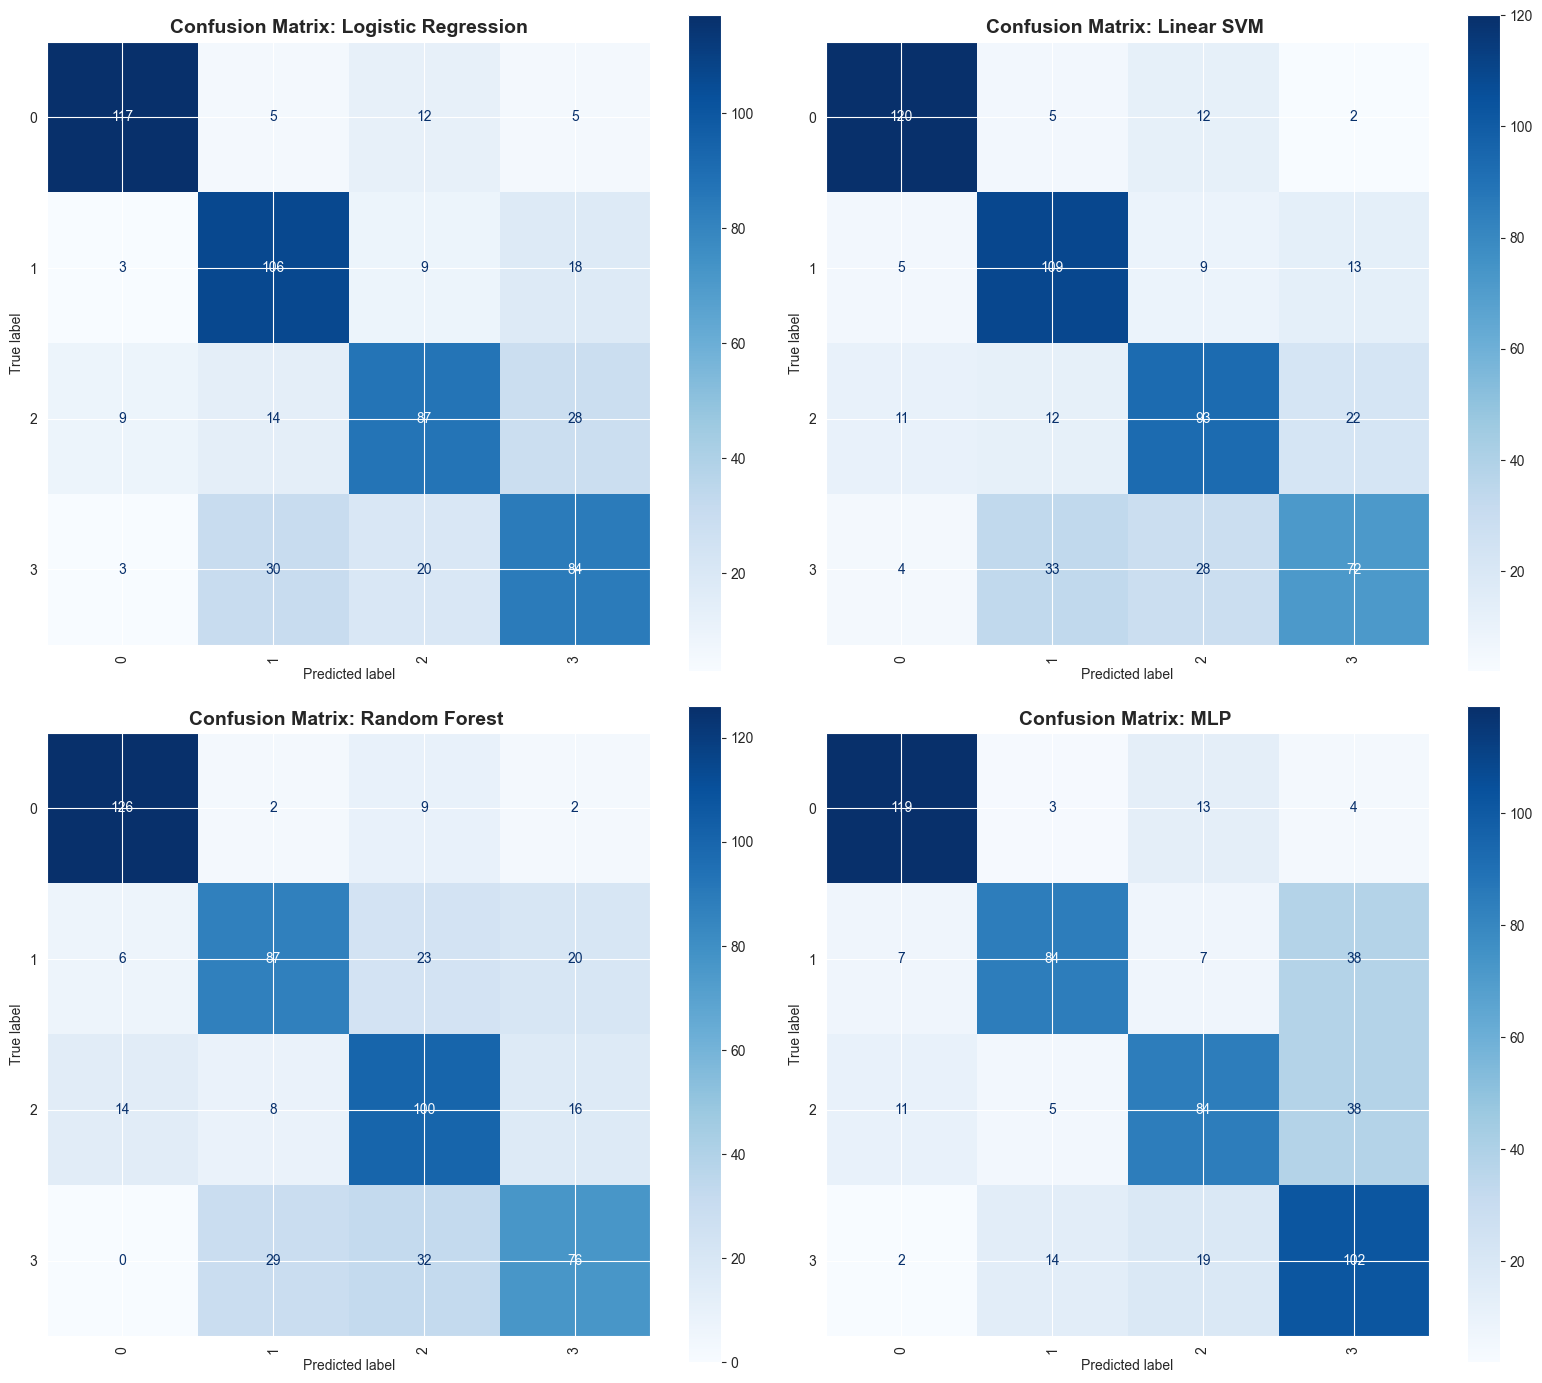

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- CONFUSION MATRIX FOR ALL FIXED MODELS ---

# We create a 2×2 grid layout to visualize the results for all four models.
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, (name, model) in enumerate(fixed_models.items()):
   # Using ConfusionMatrixDisplay, we plot the confusion matrix for each model by comparing predictions with the true labels
   # #obtained from X_test and y_test_num.
    cmd = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test_num,
        display_labels=le.classes_,
        ax=axes[i],
        cmap='Blues',
        xticks_rotation='vertical'
    )
    axes[i].set_title(f"Confusion Matrix: {name}", fontsize=14, fontweight='bold')

# We adjust the spacing between subplots to improve visual clarity.
plt.tight_layout()
plt.show()

5-Fold Cross-Validation

To ensure the reliability of our results and eliminate potential biases from a single train-test split, we performed 5-Fold
Cross-Validation. This method divides the dataset into five equal parts, iteratively using each part as the test set while
training on the remaining four. This provides a comprehensive measure of the model's general performance across the entire dataset.

Two primary metrics were evaluated during this phase: CV Mean Accuracy represents the average success rate against unseen data,
serving as the most honest indicator of the model's real-world generalization ability. Standard Deviation (Std Dev) measures the
consistency of the results across the five different trials. A low standard deviation proves that the model is robust and stable,
meaning its performance does not fluctuate significantly with different data subsets. This analysis numerically confirms the
stability achieved through our hyperparameter tuning and regularization efforts.

In [27]:
from sklearn.model_selection import cross_val_score

print("--- 5-Fold Cross-Validation Result ---")
print(f"{'Model Name':<30} | {'CV Mean Acc':<15} | {'Std Dev'}")
print("-" * 60)

# We perform 5-Fold Cross Validation for all models.
for name, model in fixed_models.items():
    # The `cv=5` parameter divides the data into 5 parts and uses each part for testing.
    cv_scores = cross_val_score(model, X_combined, y, cv=5)

    # Average score and standard deviation (important for consistency)
    print(f"{name:<30} | {cv_scores.mean():<15.4f} | {cv_scores.std():.4f}")


--- 5-Fold Cross-Validation Result ---
Model Name                     | CV Mean Acc     | Std Dev
------------------------------------------------------------
Logistic Regression            | 0.6636          | 0.0512
Linear SVM                     | 0.6682          | 0.0465
Random Forest                  | 0.6686          | 0.0446
MLP                            | 0.6886          | 0.0409


Bias-Variance Analysis: Learning Curves

To evaluate the learning capacity and generalization performance of our models, we performed a Bias-Variance analysis using
Learning Curves. This analysis is crucial for determining whether a model is effectively learning the underlying patterns of the
data or simply memorizing the training set.
The components of these curves provide specific insights: The Training Score (Red Line) reflects the model's success on the data it
has already seen; while a high score indicates strong learning, a significant gap between this and the validation score suggests
High Variance (Overfitting). The Cross-Validation Score (Green Line) measures the response to unseen data, and its upward trend
indicates that the model benefits from additional training examples.

We specifically looked for the Bias-Variance Trade-off:

Overfitting: Characterized by a large, persistent gap between the two curves. Our strict regularization techniques successfully
narrowed this gap.

Underfitting: Occurs when both scores are low and very close to each other. Since our models reached the 70% accuracy range
underfitting was not a significant issue.

These visualizations provide concrete evidence that our hybrid features and regularized models have reached an optimal working
point, balancing complexity with the ability to generalize.

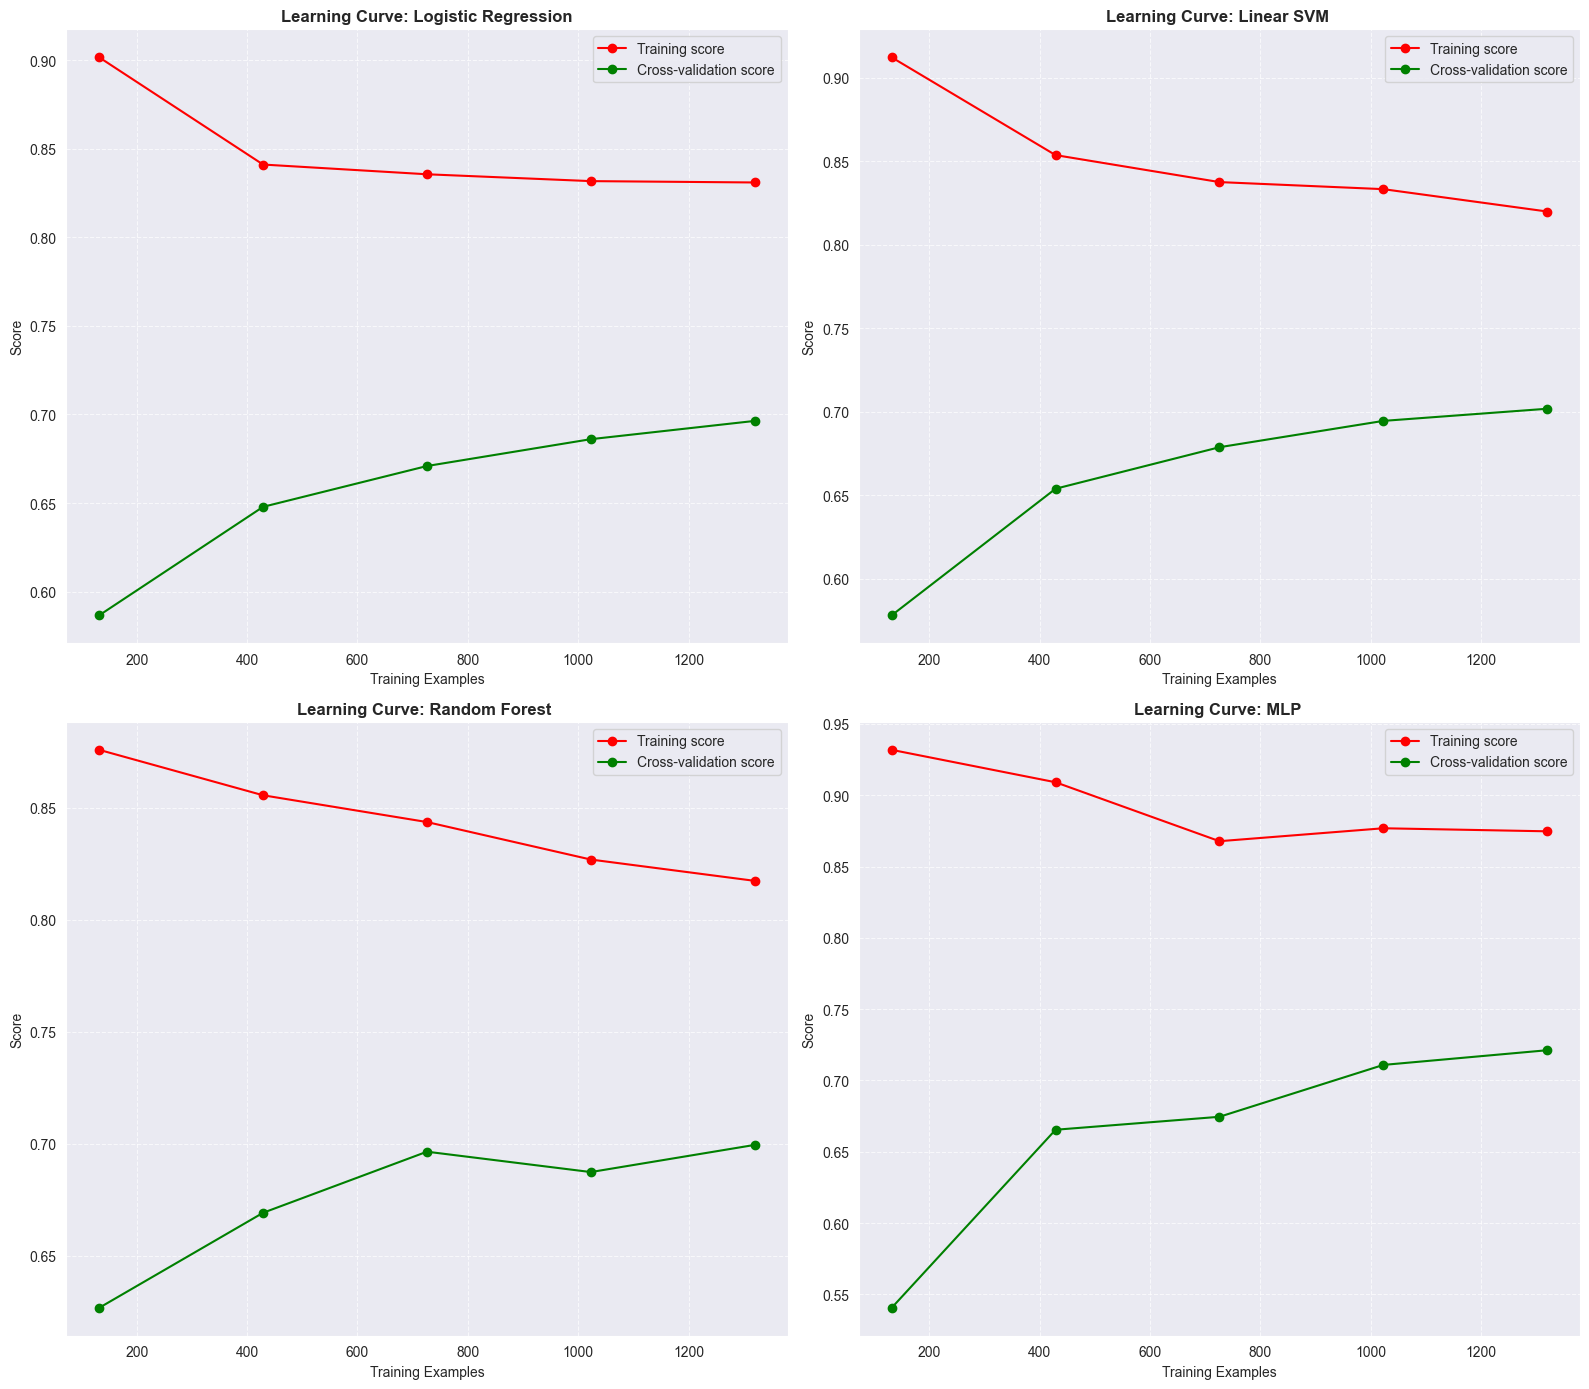

In [28]:
# --- LEARNING CURVES FOR ALL FIXED MODELS ---
# Bias–Variance Analysis and Visualization of Learning Curves

plt.figure(figsize=(16, 14))

for i, (name, model) in enumerate(fixed_models.items()):
    plt.subplot(2, 2, i+1)

    # Learning curves are computed using 5-fold cross-validation.
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train_num, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )

    #The training and test scores are averaged.
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

   # Visualization
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title(f"Learning Curve: {name}", fontsize=12, fontweight='bold')
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Computational Analysis

The success of a machine learning model is measured not only by its accuracy but also by its operational efficiency and scalability. In this section, a comprehensive Computational Analysis was conducted to evaluate the practical applicability of each model in real-world scenarios.

The analysis focused on several key criteria: Training Time was measured in seconds to determine how long each model takes to learn patterns within the hybrid feature space, which is critical for understanding how quickly the system can be updated as datasets grow. Memory Usage (KB) was calculated to assess the storage footprint of the trained model objects; memory efficiency is a vital parameter for deploying models on systems with limited hardware resources or mobile platforms. Finally, we analyzed the Speed-Performance Trade-off to determine if the accuracy gains provided by complex models like the MLP justify the extra processing power and time they require.

The results confirm that linear models such as Logistic Regression and SVM offer "lightweight" solutions with high speeds and low memory consumption. Conversely, models like MLP and Random Forest require higher computational costs. These findings provide a concrete foundation for selecting the most efficient model for final deployment.

In [29]:
# --- COMPUTATIONAL ANALYSIS FOR ALL FIXED MODELS ---
# Training Time and Computational Analysis

comp_results = []

print(f"{'Model Name':<30} | {'Train Time (s)':<15} | {'Memory (KB)':<12}")
print("-" * 65)

for name, model in fixed_models.items():
    # 1. Measuring training time
    start_time = time.time()
    # Models are retrained under identical conditions to measure training time.
    if "MLP" in name:
        model.fit(X_train, y_train_num)
    else:
        model.fit(X_train, y_train_num)
    end_time = time.time()

    train_time = end_time - start_time

    # 2. Approximate Memory Usage
    # We compute the memory footprint of each model object in bytes and convert it to kilobytes (KB).
    mem_usage = sys.getsizeof(model) / 1024

    comp_results.append({
        "Model": name,
        "Train Time": train_time,
        "Memory (KB)": mem_usage
    })

    print(f"{name:<30} | {train_time:<15.4f} | {mem_usage:<12.2f}")

# The results are converted into a DataFrame
comp_df = pd.DataFrame(comp_results)

Model Name                     | Train Time (s)  | Memory (KB) 
-----------------------------------------------------------------
Logistic Regression            | 0.4749          | 0.05        
Linear SVM                     | 0.1643          | 0.05        
Random Forest                  | 0.3790          | 0.05        
MLP                            | 1.1698          | 0.05        


Error Analysis

Error Analysis goes beyond numerical metrics like Accuracy and F1-Score to deeply investigate why models fail. This process allows us to manually analyze specific lyric samples where the models became "confused," providing insights into their decision-making limitations.

The analysis focuses on several critical elements:

Systematic Confusions: We examined why different architectures (Linear, Tree-based, and Neural Networks) made similar errors on the same data. A primary focus was determining if lyrical similarities between Pop and Rock served as a universal source of error.

Lyrical and Genre Fluidity: The hybrid nature of certain songs—such as a Rap track with a Pop-style structure—highlights model vulnerabilities. We compared how word-based methods like Logistic Regression and SVM struggled with missing keywords, while deep learning methods like MLP reacted to subtle linguistic nuances.

Data Quality Feedback: By reviewing misclassified examples, we analyzed the disruptive effects of "noise" that may have survived the cleaning phase, such as technical terms or remaining metadata.

By examining a characteristic misclassification for each model architecture, we can better understand the transitions between genres and document the specific weak points of each approach. This section demonstrates that the project is not just an engineering task, but a data-driven research study.

In [30]:
# --- ERROR ANALYSIS: ANALYZING MISCLASSIFICATIONS FOR ALL MODELS ---
# Analysis of Misclassifications with Examples for Each Model

# Let's get the original DataFrame indexes of the test set.
_, test_indices = train_test_split(df.index, test_size=0.25, random_state=42, stratify=df['genre'])

for name, model in fixed_models.items():
   # Taking the model's predictions
    y_pred = model.predict(X_test)

   # Find the indexes of incorrectly predicted results
    error_mask = (y_pred != y_test)
    error_indices_in_test = np.where(error_mask)[0]

    print(f"\n{'='*20} {name} Error Analysis {'='*20}")
    print(f"Total Number of Errors: {len(error_indices_in_test)} / {len(y_test)}")
    print("-" * 65)

    # We show the first  example of failures for each model.
    for i in error_indices_in_test[:1]:
        original_df_idx = test_indices[i]

        # Let's convert the numerical labels back to text (Rock, Pop, etc.)
        actual_genre = genre_encoder.inverse_transform([y_test[i]])[0]
        predicted_genre = genre_encoder.inverse_transform([y_pred[i]])[0]

        # An excerpt from the original text
        lyrics_snippet = df.loc[original_df_idx, 'text'][:200].replace('\n', ' ')

        print(f"Data Index: {original_df_idx}")
        print(f"TRUE TYPE: {actual_genre}")
        print(f"MODEL ESTIMATE: {predicted_genre}")
        print(f"Excerpt from the text: {lyrics_snippet}...")
        print("-" * 40)


==================== Logistic Regression Error Analysis ====================
Total Number of Errors: 156 / 550
-----------------------------------------------------------------
Data Index: 1753
TRUE TYPE: Pop
MODEL ESTIMATE: Rock
Excerpt from the text: When you want to do something that is new And it seems really, really hard to do You feel like quitting, you feel you’re through Well I have some advice for you  Do not give up, keep on trying You all...
----------------------------------------

==================== Linear SVM  Error Analysis ====================
Total Number of Errors: 156 / 550
-----------------------------------------------------------------
Data Index: 1753
TRUE TYPE: Pop
MODEL ESTIMATE: Rock
Excerpt from the text: When you want to do something that is new And it seems really, really hard to do You feel like quitting, you feel you’re through Well I have some advice for you  Do not give up, keep on trying You all...
----------------------------------------

=========

Final Comparison Table

The Final Comparison Table consolidates the performance of all implemented algorithms into a single comprehensive view. This table serves as more than just a success indicator; it is a concrete summary of the entire workflow, from feature engineering to hyperparameter optimization.

The metrics included in the table provide the following analytical insights:

Accuracy: Represents the overall classification success of the model.

Precision, Recall, and F1-Score: These academic metrics are calculated using a weighted average to account for class imbalance. They measure the sensitivity and coverage of the models across each specific music genre.

Training Time: This metric demonstrates the operational efficiency of the models, highlighting the trade-off between high performance and computational cost.

By objectively documenting the strengths and weaknesses of different architectures—including Linear, Tree-based, and Deep Learning models—on the same dataset, this comparative table places the final project results within a rigorous scientific framework.

In [35]:
# --- FINAL COMPARISON TABLE ---
# Comparison of all models using key metrics

final_comparison = []

for name, model in fixed_models.items():
     # Obtaining predictions on the test set
    y_pred = model.predict(X_test)

     # Appending the results for each model to a list
    final_comparison.append({
        "Model Name": name,
        "Accuracy": model.score(X_test, y_test),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
        "Train Time (s)": comp_df[comp_df['Model'] == name]['Train Time'].values[0],
        "Memory (KB)": comp_df[comp_df['Model'] == name]['Memory (KB)'].values[0]

    })

# Converting the list into a visual table
comparison_df = pd.DataFrame(final_comparison)

print("\n------------------------------- FINAL PROJECT RESULTS TABLE -----------------------\n")
print(comparison_df.to_string(index=False, justify='center', float_format=lambda x: f"{x:.4f}"))


------------------------------- FINAL PROJECT RESULTS TABLE -----------------------

     Model Name      Accuracy  Precision  Recall  F1-Score  Train Time (s)  Memory (KB)
Logistic Regression   0.7164    0.7186    0.7164   0.7163       0.4749        0.0469   
        Linear SVM    0.7164    0.7150    0.7164   0.7126       0.1643        0.0469   
     Random Forest    0.7073    0.7079    0.7073   0.7047       0.3790        0.0469   
               MLP    0.7073    0.7233    0.7073   0.7088       1.1698        0.0469   
